#### Import Libraries

In [23]:
import numpy as np
from skimage import feature, color, util, io
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.nn.functional import one_hot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Extract image features and image labels to x and y tensors

In [24]:
path = '../weatherconditiondataset/'
n = 1125
n_bins = 10
x = torch.zeros((n, n_bins))  # features
y = [] # labels
for i, f in enumerate(os.listdir(path)):
    # FEATURES
    img = io.imread(path+f)
    # Convert image to grayscale
    if (img.ndim == 3 and img[0, 0, :].size == 3):
        img_gray = color.rgb2gray(img)
    elif(img.ndim == 3 and img[0, 0, :].size == 4):
        img_gray = color.rgb2gray(img[:, :, :3])
    else:
        img_gray = img
    
    # Convert the image to an unsigned 8-bit integer type
    discretized_image = util.img_as_ubyte(img_gray)
    # Extract LBP features
    radius = 1
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(discretized_image, n_points, radius, method='uniform')
    # Create histogram of LBP codes
    n_bins = 10
    hist, bins = np.histogram(lbp, bins=n_bins, range=(0, n_bins), density=True)
    x[i] = torch.tensor(hist)
    # LABELS
    string = ""
    i = 0
    while(ord(f[i]) > 57):
        string += f[i]
        i = i + 1
    y.append(string)

#### Get information on labels, transform them from string to one hot

In [25]:
classNames = set(y)
classCount = {}
classNumber = {}
numbClasses = len(classNames)

for i, c in enumerate(classNames): 
    classNumber[c] =  i
for c in y: 
    classCount[c] =  classCount.get(c, 0) + 1

y_OneHot = torch.zeros((n, numbClasses))  # features

for i, c in enumerate(y):
    numb = torch.tensor(classNumber[c])
    y_OneHot[i] = one_hot(numb, num_classes = numbClasses).float()

print(classCount)
print(classNumber)

{'cloudy': 300, 'shine': 253, 'sunrise': 357, 'rain': 215}
{'cloudy': 0, 'sunrise': 1, 'rain': 2, 'shine': 3}


#### Showcase the LBP histograms for different classes

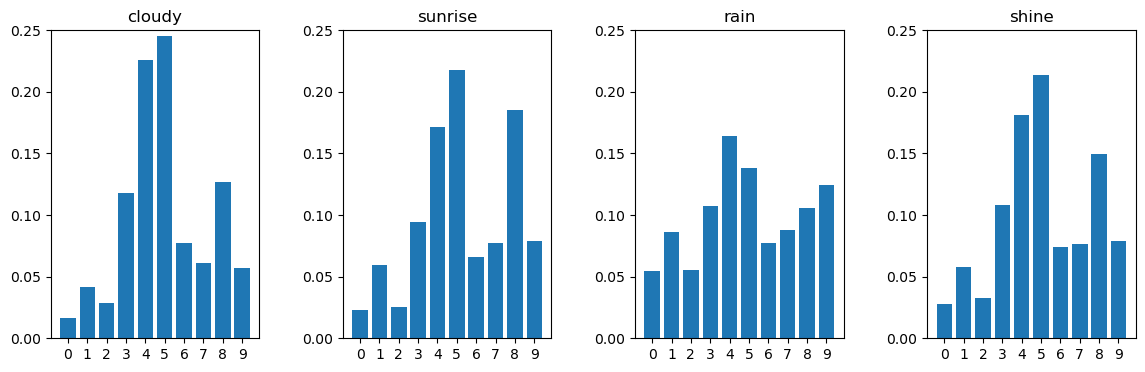

In [26]:
classMeanHist = torch.zeros(len(classNames), n_bins)

for hist, label in zip(x,y):
    classMeanHist[classNumber[label]] = classMeanHist[classNumber[label]] + hist

for c in classNames:
    classMeanHist[classNumber[c]] = classMeanHist[classNumber[c]] / classCount[c]


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14, 4), gridspec_kw={'wspace': 0.4})

# Display each image in a different subplot
for i, c in enumerate(classNames):
    axes[i].bar(bins[0:10], classMeanHist[classNumber[c]])
    axes[i].set_title(c)
    axes[i].set_ylim(0, 0.25)
    axes[i].set_xticks(bins[0:10], [int(bin) for bin in bins[0:10]])

plt.savefig("distributions.png")

plt.show()

#### Define Multi Layer Perceptron

In [41]:
# define our multilayer perceptron
# this class inherits from torch.nn.module, which is a base class for all neural network modules 
class MLP(torch.nn.Module):
        # define inputs and variables for our class
        def __init__(self, input_size, output_size):
            # initialize torch.nn.module, our superclass
            super(MLP, self).__init__()
            # number of inputs to the network
            self.input_size = input_size
            # number of our network's outputs 
            self.output_size = output_size

            self.fc1 = torch.nn.Linear(self.input_size, 512)
            self.fc2 = torch.nn.Linear(512, 512)
            self.fc3 = torch.nn.Linear(512, self.output_size)
            self.relu = torch.nn.ReLU()
            self.dropout = torch.nn.Dropout(0.2)
        # the structure of our network
        def forward(self, input):
            #print(x[0])
            x = self.relu(self.fc1(input))
            x = self.dropout(x)
            x = self.relu(self.fc2(x))
            x = self.dropout(x)  
            x = self.fc3(x)
            
            return x

#### Define model training function

In [42]:
def train_model(model, epochs, train_dataloader, foldNumb):
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.03)
  model.train()
  loss_arr = []
  acc_arr = []
  count = 0 
  bestLoss = float('inf')
  
  for i in tqdm(range(epochs)):
    tot_loss = 0.0
    tot_accuracy = 0.0
    for j, batch in enumerate(train_dataloader): 

        data, label = batch
        data = data.to(device)
        label = label.to(device)

        # parameter learning #
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        #------------------- 

        tot_loss = tot_loss + loss.item()*batch_size
        # Get the index of an array element with the highest probability
        y_pred = torch.argmax(y_pred, dim = 1)
        label = torch.argmax(label, dim = 1)
        # Count correct predictions
        accuracy = y_pred.eq(label).sum().item()
        tot_accuracy = tot_accuracy + accuracy

    avg_loss = tot_loss/len(train_dataset)
    avg_acc = tot_accuracy/len(train_dataset)
    loss_arr.append(avg_loss)
    acc_arr.append(avg_acc)
    # if(avg_loss<bestLoss)
    #   bestLoss = avg_loss
    #   count = 0
    # else 
    #   count = count + 1
    # if(count==2)
    #   print("lr going down:\n", param_group['lr'])
    #   for param_group in optimizer.param_groups:
    #     param_group['lr'] = param_group['lr']*0.99
    # print('Epoch %d | Loss %6.2f | Accuracy %2.2f' % (i,avg_loss, avg_acc))

  fig, ax = plt.subplots()
  xAxis = np.linspace(1, len(loss_arr), num=len(loss_arr))
  plt.title("Loss plot, fold #" + str(foldNumb))
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Cross Entropy Loss")
  plt.plot(xAxis, loss_arr)
  plt.savefig("lossNoGradReduction_fold" +str(foldNumb)+".png")
  plt.close()
  fig, ax = plt.subplots()
  xAxis = np.linspace(1, len(acc_arr), num=len(acc_arr))
  plt.title("Accuracy plot, fold #" + str(foldNumb))
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy")
  plt.plot(xAxis, acc_arr)
  plt.savefig("accuracyNoGradReduction_fold" +str(foldNumb)+".png")
  plt.close()

  return loss_arr[len(loss_arr)-1], acc_arr[len(acc_arr)-1]

#### Define model testing function

In [43]:
from sklearn.metrics import confusion_matrix

def test_model(model, x_test, y_test):
    model.eval()

    # Get predictions
    y_pred = model(x_test)
    # Get the index of an array element with the highest probability
    y_pred = torch.argmax(y_pred, dim = 1)
    y_test = torch.argmax(y_test, dim = 1)
    # Count correct predictions
    accuracy = y_pred.eq(y_test).sum()/torch.numel(y_pred)
    
    y_pred = y_pred.detach().cpu().numpy()
    y_test = y_test.detach().cpu().numpy()
    cm = confusion_matrix(y_test, y_pred, labels = [0, 1, 2, 3])
    
    return accuracy.item(), cm

### MAIN

In [44]:
%run ../heatmap.py
from sklearn.model_selection import KFold
import sys
sys.path.insert(1, '/media/commlab/TenTB/home/dmytro/AI_HW#1/')

batch_size = 16
# number of subprocesses to use for data loading
num_workers = 8
k = 5  # number of folds
epochs = 2000

cm_total = np.zeros((4, 4))
avg_test_acc = 0
avg_train_acc = 0
avg_train_loss = 0

# create a KFold object
kf = KFold(n_splits=k, shuffle=True)

# # shuffle the data and split it in two
# shuffled_indices = np.random.permutation(len(x))
# x = x[shuffled_indices]
# y_OneHot = y_OneHot[shuffled_indices]

# x = x[:round(n/2), :]
# y_OneHot = y_OneHot[:round(n/2), :]

# loop over the folds
i = 1
for train_index, test_index in kf.split(x):
    print("Fold #" + str(i) + ":")
    
    # split the data into training and test sets
    x_train, y_train = x[train_index], y_OneHot[train_index]
    x_test, y_test = x[test_index], y_OneHot[test_index]

    # zip the data and its labels into a dataset
    train_dataset = TensorDataset(x_train, y_train)
    # pass the data into dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # create an instance of the model
    model = MLP(n_bins, len(classNames)).to(device)

    train_loss, train_acc = train_model(model, epochs, train_dataloader, i)
    test_acc, cm = test_model(model, x_test.to(device), y_test.to(device))

    avg_train_loss += train_loss
    avg_train_acc += train_acc
    avg_test_acc += test_acc
    cm_total = cm_total + cm

    i = i + 1

print("Average training loss:", round(avg_train_loss/k, 2))
print("Average training accuracy:", str(round(avg_train_acc/k*100, 2)) + "%")
print("Average test accuracy:", str(round(avg_test_acc/k*100, 2)) + "%")
grid_labels = ['cloudy', 'sunrise', 'shine', 'rain']
# compute the sum of each row
row_sums = cm_total.sum(axis=1)
cm_normalized = cm_total / row_sums[:, np.newaxis]
im, cbar = heatmap(cm_normalized, grid_labels, grid_labels)
annotate_heatmap(im)
plt.savefig("accuracyNoGradReduction_confusionMatrix.png")
plt.close()

Fold #1:


100%|██████████| 2000/2000 [10:48<00:00,  3.08it/s]


Fold #2:


100%|██████████| 2000/2000 [10:46<00:00,  3.09it/s]


Fold #3:


100%|██████████| 2000/2000 [10:47<00:00,  3.09it/s]


Fold #4:


100%|██████████| 2000/2000 [10:47<00:00,  3.09it/s]


Fold #5:


100%|██████████| 2000/2000 [10:45<00:00,  3.10it/s]


Average training loss: 0.75
Average training accuracy: 70.15%
Average test accuracy: 54.83%


<b>full data 512 nodes network</b><br>
Average training loss: 0.75<br>
Average training accuracy: 70.15%<br>
Average test accuracy: 54.83%<br>

<b>half data 512 nodes network </b> <br>
Average training loss: 0.71 <br>
Average training accuracy: 70.73% <br>
Average test accuracy: 59.45%

<b>full data 10 nodes network</b><br>
Average training loss: 1.11 <br>
Average training accuracy: 51.95% <br>
Average test accuracy: 54.45%

<b>half data 10 nodes network</b> <br>
Average training loss: 1.08 <br>
Average training accuracy: 53.78% <br>
Average test accuracy: 55.35% <br>

In [48]:
if torch.cuda.is_available():
    print(f'{torch.cuda.device_count()} GPU(s) are available!')
    for i in range(torch.cuda.device_count()):
        print(f'GPU {i}: {torch.cuda.get_device_name(i)}')
        print(f'\tCompute capability: {torch.cuda.get_device_capability(i)}')
        print(f'\tMemory: {torch.cuda.get_device_properties(i).total_memory / 1024 ** 2:.2f} MB')
else:
    print('CUDA is not available.')


2 GPU(s) are available!
GPU 0: NVIDIA GeForce RTX 2080 Ti
	Compute capability: (7, 5)
	Memory: 11019.56 MB
GPU 1: NVIDIA GeForce RTX 2080 Ti
	Compute capability: (7, 5)
	Memory: 11018.25 MB
